In [1]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove2word2vec(glove_input_file="embeddings/glove/glove.twitter.27B.200d.txt", word2vec_output_file="embeddings/glove/gensim_glove.twitter.27B.200d.txt")

(1193517, 200)

In [2]:
from gensim.models.keyedvectors import KeyedVectors
glove_model = KeyedVectors.load_word2vec_format("embeddings/glove/gensim_glove.twitter.27B.200d.txt", binary=False)

In [29]:
import pandas as pd
with open('data/train.jsonl') as f:
    train_data = pd.read_json(f, lines=True)
with open('data/test.jsonl') as f:
    test_data = pd.read_json(f, lines=True)

In [30]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y = le.fit_transform(train_data['label'])

In [31]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
train_data['response'] = train_data['response'].apply(tokenizer.tokenize)
train_data['context'] = train_data['context'].str.join(' ').apply(tokenizer.tokenize)

In [32]:
train_data.head()

,label,response,context
0,SARCASM,"[@USER, @USER, @USER, I, don't, get, this, ..,...","[A, minor, child, deserves, privacy, and, shou..."
1,SARCASM,"[@USER, @USER, trying, to, protest, about, ., ...","[@USER, @USER, Why, is, he, a, loser, ?, He's,..."
2,SARCASM,"[@USER, @USER, @USER, He, makes, an, insane, a...","[Donald, J, ., Trump, is, guilty, as, charged,..."
3,SARCASM,"[@USER, @USER, Meanwhile, Trump, won't, even, ...","[Jamie, Raskin, tanked, Doug, Collins, ., Coll..."
4,SARCASM,"[@USER, @USER, Pretty, Sure, the, Anti-Lincoln...","[Man, ..., y, ’, all, gone, “, both, sides, ”,..."


<AxesSubplot:>

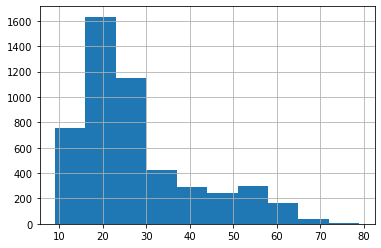

In [74]:
train_data['response'].apply(len).hist()

<AxesSubplot:>

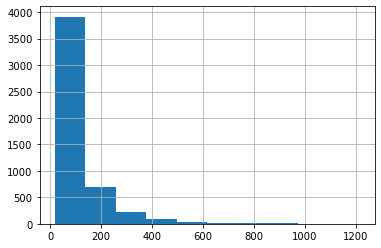

In [75]:
train_data['context'].apply(len).hist()

In [41]:
from sklearn.feature_extraction.text import CountVectorizer

def dummy(doc):
    return doc

cv = CountVectorizer(
        tokenizer=dummy,
        preprocessor=dummy, min_df=5, max_df=0.5)  

cv.fit(train_data['response'])
cv.fit(train_data['context'])

/Users/astrok/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


CountVectorizer(max_df=0.5, min_df=5,
                preprocessor=<function dummy at 0x7fa8a2bcdee0>,
                tokenizer=<function dummy at 0x7fa8a2bcdee0>)

In [46]:
vocab = {key: idx for idx, key in enumerate(cv.vocabulary_.keys())}

In [67]:
vocab_size = len(vocab)
vocab_size

7280

In [71]:
import numpy as np
emb_weights = np.zeros((len(vocab), glove_model.vector_size))
for k, idx in vocab.items():
    if k in glove_model.vocab:
        emb_weights[idx, :] = glove_model[k]

In [72]:
emb_weights.shape

(7280, 200)

In [135]:
train_data['response_vec'] = train_data['response'].apply(lambda tokens: [vocab[t] for t in tokens if t in vocab])

In [136]:
maxlen = 300

def truncate_vec(vec):
    x = np.zeros(maxlen, dtype='float32')
    np.put(x, np.arange(0, min(len(vec), maxlen)) ,vec[-maxlen:] if len(vec) > maxlen else vec)
    return x
    
X = train_data['response_vec'].apply(truncate_vec)
X = np.stack(X.to_numpy())

In [137]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
train_index, test_index = next(sss.split(X, y))
X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]

In [83]:
from keras.models import Sequential, model_from_json
from keras.layers.core import Dropout, Dense, Activation, Flatten, Reshape
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.utils import np_utils
from collections import defaultdict
import tensorflow.keras.backend as K


In [73]:
#https://github.com/AniSkywalker/SarcasmDetection/blob/master/src/sarcasm_detection_model_CNN_LSTM_DNN_word2vec.py
hidden_units=256
trainable=False


model = Sequential()
model.add(Embedding(vocab_size, emb_weights.shape[1], input_length=maxlen, weights=[emb_weights],
                    trainable=trainable))

# model.add(Reshape((maxlen, emb_weights.shape[1], 1)))

model.add(Convolution1D(emb_weights.shape[1], 3, kernel_initializer='he_normal', padding='valid',
                        activation='sigmoid',
                        input_shape=(1, maxlen)))
# model.add(MaxPooling1D(pool_size=3))

model.add(Convolution1D(emb_weights.shape[1], 3, kernel_initializer='he_normal', padding='valid',
                        activation='sigmoid',
                        input_shape=(1, maxlen - 2)))
# model.add(MaxPooling1D(pool_size=3))

model.add(Dropout(0.25))

model.add(LSTM(hidden_units, kernel_initializer='he_normal', activation='sigmoid', dropout=0.5,
               return_sequences=True))
model.add(LSTM(hidden_units, kernel_initializer='he_normal', activation='sigmoid', dropout=0.5))

model.add(Dense(hidden_units, kernel_initializer='he_normal', activation='sigmoid'))
model.add(Dense(2, activation='softmax'))
adam = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
print('No of parameter:', model.count_params())

print(model.summary())

No of parameter: 2755986
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 200)          1456000   
_________________________________________________________________
conv1d (Conv1D)              (None, 298, 200)          120200    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 296, 200)          120200    
_________________________________________________________________
dropout (Dropout)            (None, 296, 200)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 296, 256)          467968    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense (Dense)                

In [ ]:
modelCheckpoint = ModelCheckpoint('best_sarcasm_model.hdf5', save_best_only = True)
model.fit(K.constant(X_train), np_utils.to_categorical(y_train, num_classes = 2), batch_size=8, epochs=100, validation_data=(K.constant(X_test), np_utils.to_categorical(y_test, num_classes = 2)), shuffle=True, callbacks=[modelCheckpoint])

Epoch 1/100
438/438 [==============================] - 148s 338ms/step - loss: 0.7023 - accuracy: 0.4963 - val_loss: 0.6980 - val_accuracy: 0.5000
Epoch 2/100
438/438 [==============================] - 152s 347ms/step - loss: 0.6977 - accuracy: 0.4966 - val_loss: 0.7028 - val_accuracy: 0.5000
Epoch 3/100
438/438 [==============================] - 145s 331ms/step - loss: 0.6977 - accuracy: 0.4974 - val_loss: 0.7113 - val_accuracy: 0.5000
Epoch 4/100
438/438 [==============================] - 145s 330ms/step - loss: 0.7002 - accuracy: 0.4891 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 5/100
438/438 [==============================] - 150s 342ms/step - loss: 0.6956 - accuracy: 0.5046 - val_loss: 0.6938 - val_accuracy: 0.5000
Epoch 6/100
438/438 [==============================] - 164s 373ms/step - loss: 0.6961 - accuracy: 0.4954 - val_loss: 0.6955 - val_accuracy: 0.5000
Epoch 7/100
438/438 [==============================] - 145s 332ms/step - loss: 0.6976 - accuracy: 0.4866 - val_loss: 0

array([[ 153.,  126.,  115., ...,    0.,    0.,    0.],
       [1794.,  293.,  701., ...,    0.,    0.,    0.],
       [ 376.,   88.,  121., ...,    0.,    0.,    0.],
       ...,
       [1279., 1029.,  397., ...,    0.,    0.,    0.],
       [   0.,  421.,   89., ...,    0.,    0.,    0.],
       [6472.,  403.,  751., ...,    0.,    0.,    0.]], dtype=float32)